In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

import matplotlib.pyplot as plt
import numpy as np

# Test of stationarity
from statsmodels.tsa.stattools import adfuller

# Linear Optimization
from scipy.optimize import minimize

In [3]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Functions for empirical moments
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)

    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat


In [4]:
DATA_PATH = "StockPrice_JPM_AAPL_BP.xlsx"

In [5]:
df = pd.read_excel(DATA_PATH, sheet_name=None)
df_aggregated = df_of_aggregated_data(df)
df_aggregated_in_datetime = convert_index_to_datetime(df_aggregated)
df_clean = transform_df_with_str_values_into_float(df_aggregated_in_datetime, columns_to_change = df_aggregated_in_datetime.columns.drop('Ticker'))

In [7]:
df_clean = df_clean[['Adj Close',"Ticker"]]

In [8]:
df_clean = df_clean[df_clean['Ticker']== 'AAPL'][['Adj Close']].rename(columns = {'Adj Close': 'AAPL'}).merge(df_clean[df_clean['Ticker']== 'JPM'][['Adj Close']].rename(columns = {'Adj Close': 'JPM'}),left_index=True, right_index=True).merge(df_clean[df_clean['Ticker']== 'BP'][['Adj Close']].rename(columns = {'Adj Close': 'BP'}),left_index=True, right_index=True)

In [9]:
# Calculating returns

Y = df_clean.pct_change().dropna()

Y

,AAPL,JPM,BP
Date,,,
1985-02-01,-14.6550%,5.0000%,0.5602%
1985-03-01,-10.6059%,-4.7619%,6.9610%
1985-04-01,-3.9552%,2.6316%,4.4973%
1985-05-01,-18.2352%,9.2409%,-3.0381%
1985-06-01,3.5972%,-0.3021%,-0.6320%
...,...,...,...
2023-07-01,1.2785%,8.6084%,5.6956%
2023-08-01,-4.3675%,-6.7264%,-0.3217%
2023-09-01,-8.7448%,-0.8952%,5.3697%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [10]:
import riskfolio as rp


# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,JPM,BP
weights,42.2531%,28.1403%,29.6065%


### 2.2 Plotting portfolio composition

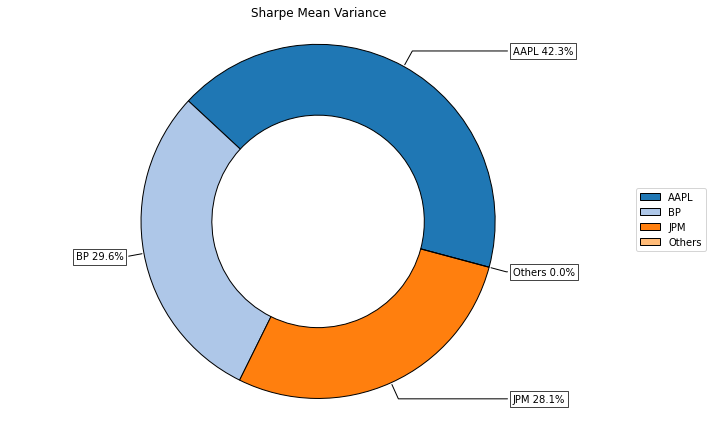

In [11]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Calculate efficient frontier

In [12]:
points = 50# Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier.T.head()

,AAPL,JPM,BP
0,13.3271%,28.8009%,57.8720%
1,23.0467%,28.5836%,48.3698%
2,27.1412%,28.4880%,44.3708%
3,30.3284%,28.4146%,41.2571%
4,33.0532%,28.3511%,38.5957%


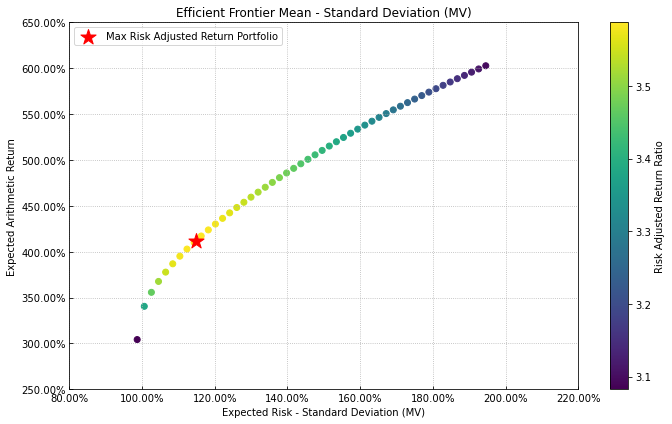

In [15]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Mean Risk Portfolios

In this part I will calculate optimal portfolios for several risk measures. First I'm going to calculate the portfolio that maximizes risk adjusted return when CVaR is the risk measure, then I'm going to calculate the portfolios that maximize the risk adjusted return for all available risk measures.

### 3.1 Calculating the portfolio that maximizes Return/CVaR ratio.

In [ ]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

### 3.2 Plotting portfolio composition

In [ ]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3 Calculate efficient frontier

In [ ]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

In [ ]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

### 3.4 Calculate Optimal Portfolios for Several Risk Measures

In [ ]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [ ]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

In [ ]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)